In [1]:
import numpy as np
from scipy import optimize

import seaborn as sns
import matplotlib.pyplot as plt

## Common Settings

$p$ predictors $\sim\mathcal{N}(\textbf{0},S)$ where $S=(s_{ij}),s_{ij}=\rho^{|i-j|}$

true coefficents $\beta_j\sim\mathcal{N}(0,0.5)$

In [2]:
n = 50 # design a), b), d), e), g)
# n = 100 # design c), f)
p = 2000

In [3]:
# rho = 0.6 # designa a), c), e), f)
# rho = 0.5 # design b)
rho = 0 # design d), g)
S = np.zeros((p,p))
for i in range(p):
    for j in range(p):
        S[i][j] = pow(rho,abs(i-j))

In [4]:
true_regressors = [40*(j-1) for j in range(1,51)]

In [5]:
def calc_mu_tilda(w):
    H_tilda_w = np.zeros((n,n))
    for k in range(M):
        H_tilda_w += H_tilda[k]*w[k]
    mu_tilda = np.dot(H_tilda_w,y)
    
    return mu_tilda

def calc_mu_tilda2(w):
    H_tilda_w2 = np.zeros((n,n))
    for k in range(M2):
        H_tilda_w2 += H_tilda2[k]*w[k]
    mu_tilda2 = np.dot(H_tilda_w2,y)
    
    return mu_tilda2

In [6]:
CV = lambda w: np.dot((y-calc_mu_tilda(w)).T,y-calc_mu_tilda(w))
CV2 = lambda w: np.dot((y-calc_mu_tilda2(w)).T,y-calc_mu_tilda2(w))

### MCV1

In [7]:
msel1 = np.zeros(100)
msel2 = np.zeros(100)
msel3 = np.zeros(100)
msel4 = np.zeros(100)
d = np.zeros(100)
d2 = np.zeros(100)
for itr in range(100):
    # regressors
    X = np.random.multivariate_normal(np.zeros(p),S,n)
    
    # design b)
#     s_alpha = np.zeros(n)
#     for i in range(n):
#         tmp_sum = 0
#         for k in true_regressors:
#             tmp_sum += abs(X[i][k])
#         s_alpha[i] = tmp_sum/50
    
#     beta = np.zeros(p)
#     for i in range(50):
#         rand = np.random.uniform(0,1)

#         if rand <= 0.7:
#             beta[true_regressors[i]] = s_alpha[i]*np.random.normal(0,0.8)
#         else:
#             beta[true_regressors[i]] = s_alpha[i]*np.random.standard_t(3)

#     epsilon = np.zeros(n)
#     for i in range(n):
#         rand = np.random.uniform(0,1)
        
#         if rand <= 0.5:
#             epsilon[i] = s_alpha[i]*np.random.normal(0,1)
#         else:
#             epsilon[i] = s_alpha[i]*np.random.standard_t(5)

    # design a), c), d), e), f), g)
    beta = np.zeros(p)
    for i in true_regressors:
        beta[i] = np.random.normal(0,0.5)
        
#     epsilon = np.random.normal(0,0.2,n) # design a), c), d)
    
    # design e), f), g)
    epsilon = np.zeros(n)
    for i in range(n):
        epsilon[i] = np.random.normal(0,np.random.uniform(2.1,2.3))
    
    # response
    true_mu = np.dot(X,beta)
    y = true_mu+epsilon
    
    # estimated marginal correlation btw predictor and response and sort
    r = np.dot(X.T,y)/n
    sorted_indices = np.argsort(r)[::-1]
    
    # MCV1
    M = 10 # number of candidate models
    nh = 10 # number of regressors in each model
    H = np.array([np.dot(np.dot(X[:,sorted_indices[int(k*nh):int((k+1)*nh+1)]],
                                np.linalg.inv(np.dot(X[:,sorted_indices[int(k*nh):int((k+1)*nh+1)]].T,
                                                     X[:,sorted_indices[int(k*nh):int((k+1)*nh+1)]]))),
                                                     X[:,sorted_indices[int(k*nh):int((k+1)*nh+1)]].T) 
                  for k in range(M)]) # hat matrix
    
    D = np.array([np.diag(1/(1-np.diag(H[k]))) for k in range(M)])
    H_tilda = np.array([np.dot(D[k],H[k]-np.eye(n))+np.eye(n) for k in range(M)]) # smoothing matrix
    
    bnds = [[0,1] for k in range(M)]
    wt = optimize.minimize(CV,np.random.uniform(0,1,M),bounds=bnds)
    wt2 = optimize.minimize(CV,np.random.uniform(0,1,M))
    
    d[itr] = sum([wt.x[i]-wt2.x[i] for i in range(len(wt.x))])
    
    estimated_mu1 = np.dot(sum([wt.x[i]*H[i] for i in range(len(wt.x))]),y)
    estimated_mu2 = np.dot(sum([wt2.x[i]*H[i] for i in range(len(wt2.x))]),y)
    mse1 = np.mean((true_mu-estimated_mu1)**2)
    mse2 = np.mean((true_mu-estimated_mu2)**2)
    
    msel1[itr] = mse1
    msel2[itr] = mse2
    
    # MCV2
    M2 = 8 # number of candidate models
    h2 = [0.05*j for j in range(1,9)]
    nh2 = [-1,*[n*h2[k] for k in range(len(h2))]] # number of regressors in each model
    H2 = np.array([np.dot(np.dot(X[:,sorted_indices[int(nh2[k]+1):int(nh2[k+1]+1)]],
                                np.linalg.inv(np.dot(X[:,sorted_indices[int(nh2[k]+1):int(nh2[k+1]+1)]].T,
                                                     X[:,sorted_indices[int(nh2[k]+1):int(nh2[k+1]+1)]]))),
                                                     X[:,sorted_indices[int(nh2[k]+1):int(nh2[k+1]+1)]].T) 
                  for k in range(M2)]) # hat matrix
    
    D2 = np.array([np.diag(1/(1-np.diag(H2[k]))) for k in range(M2)])
    H_tilda2 = np.array([np.dot(D2[k],H2[k]-np.eye(n))+np.eye(n) for k in range(M2)]) # smoothing matrix
    
    bnds2 = [[0,1] for k in range(M2)]
    wt3 = optimize.minimize(CV2,np.random.uniform(0,1,M2),bounds=bnds2)
    wt4 = optimize.minimize(CV2,np.random.uniform(0,1,M2))
    
    d2[itr] = sum([wt3.x[i]-wt4.x[i] for i in range(len(wt3.x))])
    
    estimated_mu3 = np.dot(sum([wt3.x[i]*H2[i] for i in range(len(wt3.x))]),y)
    estimated_mu4 = np.dot(sum([wt4.x[i]*H2[i] for i in range(len(wt4.x))]),y)
    mse3 = np.mean((true_mu-estimated_mu3)**2)
    mse4 = np.mean((true_mu-estimated_mu4)**2)
    
    msel3[itr] = mse3
    msel4[itr] = mse4
    
    
    if itr < 5:
        print(wt.x)
        print(wt2.x)
        print(wt3.x)
        print(wt4.x)
        print('------')


[0.297665   0.35395743 0.22057813 0.12660305 0.10352917 0.2385996
 0.23554003 0.29483343 0.06390946 0.        ]
[ 0.30765918  0.35654428  0.20787961  0.13763922  0.11601147  0.22998848
  0.24159526  0.29253194  0.08066136 -0.05757117]
[0.41711071 0.25090961 0.37035617 0.3980514  0.63825134 0.31602014
 0.46247994 0.59391348]
[0.41710612 0.25091786 0.37035832 0.3980469  0.63824866 0.31601423
 0.46247733 0.59391567]
------
[0.22568291 0.23159278 0.21285674 0.14753616 0.23470678 0.03091954
 0.08665187 0.20477885 0.20450482 0.1569056 ]
[0.22568292 0.23159284 0.21285676 0.14753627 0.23470647 0.0309197
 0.08665186 0.20477862 0.2045049  0.15690534]
[0.54497741 0.         0.36762852 0.28227652 0.3424083  0.35370237
 0.32588256 0.15957296]
[ 0.55488022 -0.04453854  0.37650081  0.28443652  0.34584878  0.36592269
  0.32449918  0.16993522]
------
[0.33074172 0.1474564  0.39350954 0.12861422 0.13144158 0.08870146
 0.1955331  0.16617942 0.         0.14560469]
[ 0.3302106   0.14937374  0.38723043  0.1

<AxesSubplot:>

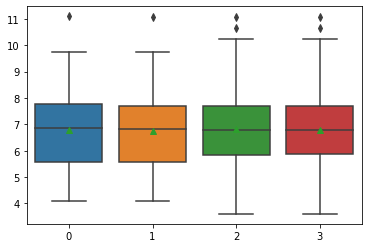

In [8]:
sns.boxplot(data=[msel1, msel2, msel3, msel4],showmeans=True,)

In [9]:
print(np.mean(d), np.mean(d2), np.mean([msel1[i]-msel2[i] for i in range(100)]),
      np.mean([msel3[3]-msel4[i] for i in range(100)]))

0.009986631374160872 0.007173934491275776 0.02678280353041137 -3.195494981479559


In [10]:
# def remove_outliers(arr):
#     q75,q25 = np.percentile(arr,[75,25])
#     intr_qr = q75-q25

#     max = q75+(1.5*intr_qr)
#     min = q25-(1.5*intr_qr)

#     arr[arr>max]=0
#     arr[arr<min]=0
    
#     return arr

# msel1 = remove_outliers(msel1)
# msel2 = remove_outliers(msel2)
# msel3 = remove_outliers(msel3)
# msel4 = remove_outliers(msel4)

# sns.boxplot(data=[msel1, msel2, msel3, msel4],showmeans=True,)